In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
landmarks_frame = pd.read_csv('../faces/face_landmarks.csv')

In [3]:
len(landmarks_frame)

69

In [4]:
n = 65

img_name = landmarks_frame.iloc[n,0]                     #找到第65 + 2个图片
landmarks = landmarks_frame.iloc[n,1:].as_matrix()       #取得该图片的所有landmarks
landmarks = landmarks.astype('float').reshape(-1,2)      #将landmarks 分为两列。-1表示不确定有多少行，但是确定要分为两列

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))     # 取出前4行

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


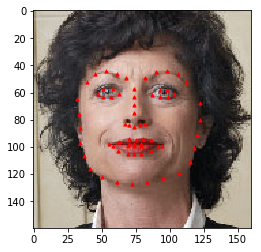

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='^', c='r') ### 取第0列的所有点作为x，取第1列的所有点作为y
    
    #plt.plt.scatter(landmarks[0, 0], landmarks[0, 1], s=10, marker='_', c='r')  ## 解开注释则只标记一个点
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('../faces/', img_name)),
               landmarks)
plt.show()

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

+ __len____ so that len(dataset) returns the size of the dataset.
+ __getitem__ to support the indexing such that dataset[i] can be used to get i

Sample of our dataset will be a dict {'image': image, 'landmarks': landmarks}

In [6]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(landmarks_frame)
    def __getitem__(self, idx):
        img_name = self.landmarks_frame.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, img_name)
        image = io.imread(img_name)                          ###使用skimage.io.imread读取图片，将图片以ndarry表示
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()    ### 将dataframe转成matrix，找到第idx行，第一列之后的所有
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)


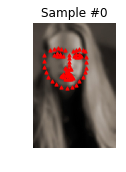

1 (500, 333, 3) (68, 2)


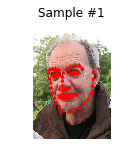

2 (250, 258, 3) (68, 2)


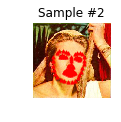

3 (434, 290, 3) (68, 2)


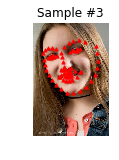

In [7]:
face_dataset = FaceLandmarksDataset('../faces/face_landmarks.csv', '../faces')
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i,sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(sample['image'],sample['landmarks'])
    if i == 3:
        plt.show()
        break


+    Rescale: to scale the image    __按比例缩进__
+    RandomCrop: to crop from image randomly. This is data augmentation.
+    ToTensor: to convert the numpy images to torch images (we need to swap axes).

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement **\__call__** method and if required, **\__init__** method. We can then use a transform like this:

tsfm = Transform(params)

transformed_sample = tsfm(sample)

About \__call__, see this link: https://blog.csdn.net/Yaokai_AssultMaster/article/details/70256621

**\__init__**  function to construct a instance, **\__call__** function make this instance callable


In [8]:
class Rescale(object):
    
    """
       Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size,(int, tuple))  
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h>w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        
        landmarks = landmarks * [new_w/w, new_h/h]  ## h is height, w is width, so x * w, y * h
        
        return {'image': img, 'landmarks': landmarks}            

Before image shape is (500, 333, 3)
After Rescaled, image shape is (384, 256, 3)


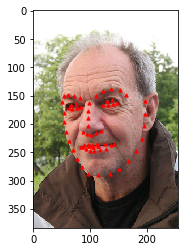

In [9]:
scale = Rescale(256)   ### input is int
sample = face_dataset[1]
rescaled_sample = scale(sample)
print("Before image shape is {}".format(sample['image'].shape))
print("After Rescaled, image shape is {}".format(rescaled_sample['image'].shape))
show_landmarks(rescaled_sample['image'],rescaled_sample['landmarks'])

Before image shape is (500, 333, 3)
After Rescaled, image shape is (256, 256, 3)


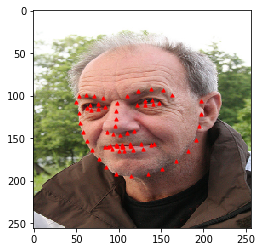

In [10]:
scale = Rescale((256,256))   ### input is tuple
sample = face_dataset[1]
rescaled_sample = scale(sample)
print("Before image shape is {}".format(sample['image'].shape))
print("After Rescaled, image shape is {}".format(rescaled_sample['image'].shape))
show_landmarks(rescaled_sample['image'],rescaled_sample['landmarks'])

In [11]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)
        
        image = image[top: top + new_h, 
                     left: left + new_w]
        
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}        

Before image shape is (500, 333, 3)
After Rescaled, image shape is (224, 224, 3)


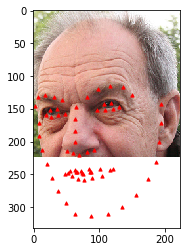

In [12]:
crop = RandomCrop(224)   ### input is int
sample = face_dataset[1]
croped_sample = crop(sample)
print("Before image shape is {}".format(sample['image'].shape))
print("After Rescaled, image shape is {}".format(croped_sample['image'].shape))
show_landmarks(croped_sample['image'],croped_sample['landmarks'])

直接crop 会导致样本丢失， 如果先rescale, 再crop 则会好些

Before image shape is (500, 333, 3)
After Rescaled, image shape is (384, 256, 3)


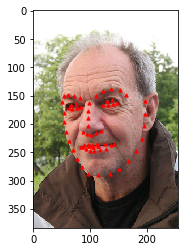

Before image shape is (384, 256, 3)
After crop, image shape is (224, 224, 3)


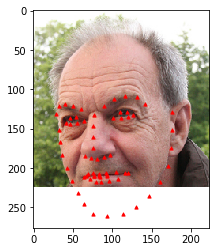

In [13]:
scale = Rescale((256))   ### input is tuple
sample = face_dataset[1]
rescaled_sample = scale(sample)
print("Before image shape is {}".format(sample['image'].shape))
print("After Rescaled, image shape is {}".format(rescaled_sample['image'].shape))
show_landmarks(rescaled_sample['image'],rescaled_sample['landmarks'])


crop = RandomCrop(224)   ### input is int
croped_sample = crop(rescaled_sample)
print("Before image shape is {}".format(rescaled_sample['image'].shape))
print("After crop, image shape is {}".format(croped_sample['image'].shape))
show_landmarks(croped_sample['image'],croped_sample['landmarks'])

In [14]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

### 第一张图单独进行rescale(256)
### 第二张图在原图基础上单独进行 crop(128)
### 第三张图先rescale(256), 再进行crop(224)

The original shape is (500, 333, 3)
after Rescale, the shape is (384, 256, 3)


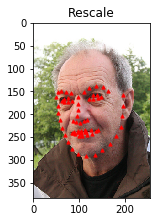

after RandomCrop, the shape is (128, 128, 3)


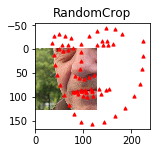

after Compose, the shape is (224, 224, 3)


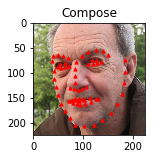

In [15]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224),
                              ])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[1]
print("The original shape is {}".format(sample['image'].shape))
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    print("after {}, the shape is {}".format(type(tsfrm).__name__, transformed_sample['image'].shape))
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

   + An image is read from the file on the fly
   + Transforms are applied on the read image
   + Since one of the transforms is random, data is augmentated on sampling


In [16]:
transformed_dataset = FaceLandmarksDataset(csv_file='../faces/face_landmarks.csv',
                                           root_dir='../faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


__torch.utils.data.DataLoader__ is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
5 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
images_batch.size is torch.Size([4, 3, 224, 224])


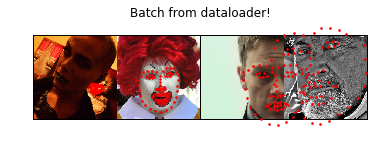

In [17]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    print("images_batch.size is {}".format(images_batch.size()))
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader!')

for i_batch, sample_batched in enumerate(dataloader):    ### dataloader 每次出来一个batch, 每个batch
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size(),
         sample_batched['image'].float().type(),
         )

    # observe 6th batch and stop.  只显示第六个batch的四张图
    if i_batch == 5:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


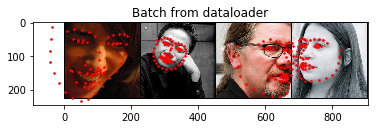

In [18]:
for idx, sample_batched in enumerate(dataloader):
    if idx==1 :
        
        images_batch, landmarks_batch = \
                sample_batched['image'], sample_batched['landmarks']
        batch_size = len(images_batch)
        im_size = images_batch.size(2)

        grid = utils.make_grid(images_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

        for i in range(batch_size):
            plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                        landmarks_batch[i, :, 1].numpy(),
                        s=10, marker='.', c='r')

            plt.title('Batch from dataloader')

In [19]:
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
save_path = '../pytorchNote/face_detection'
def train_model(model, criterion, optimizer, scheduler, num_epoch = 1):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000
    
    for epoch in range(num_epoch):
        
        print('Epoch {}/{}'.format(epoch, num_epoch-1))
        print("-" * 20)
        
        model.train()
        
        running_loss = 0.0
        
        for sample_batched in dataloader:
            images_batch = sample_batched['image']
            landmarks_batch = sample_batched['landmarks']
            #print("landmarks_batch size is {}".format(landmarks_batch.size()))
            images_batch = images_batch.to(device)
            landmarks_batch = landmarks_batch.to(device)
            
            optimizer.zero_grad()
        
            with torch.set_grad_enabled(True):
                print("input size to model is {}".format(images_batch.size()))
                exit(0)
                outputs = model(images_batch.float())
                outputs = outputs.view(outputs.size(0),68,-1)


                #print("output size is {}, type is {}".format(outputs.size(), outputs.type()))
                #print("landmarks_batch size is {}, type is {}".format(landmarks_batch.size(), landmarks_batch.type()))
                
                different = outputs - landmarks_batch.float()
                
                #print("outputs - landmarks_batch is {}, type is {}".format(different, different.type()))
                #print("current epoch is {}".format(epoch))
                loss = torch.norm(different)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * images_batch.size(0)
        
        epoch_loss = running_loss / 69
        print('Loss: {:.4f}'.format(epoch_loss))
        
        if epoch_loss < best_loss:
            print("save best ")
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(),save_path)
    
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed //60, time_elapsed %60))
    
    model.load_state_dict(best_model_wts)
    return model

In [20]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 68*2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.009, momentum= 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epoch=500)

Epoch 0/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 2218.6973
save best 
Epoc

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 1086.6296
Epoch 9/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to m

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 1015.3506
Epoch 18/499
--------------------
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 1017.2544
Epoch 26/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 1060.0497
Epoch 34/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 1069.3757
Epoch 43/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 852.4957
save best 
Epoch 52/499
--------------------
inpu

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 1010.5464
Epoch 60/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 944.0790
Epoch 69/499
--------------------
input size to m

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 809.5538
save best 
Epoch 77/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
inpu

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 881.3287
Epoch 86/499
--------------------
input size to m

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 867.4585
Epoch 94/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to m

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 750.6241
save best 
Epoch 103/499
--------------------
inp

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 777.3927
Epoch 111/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 684.8318
save best 
Epoch 119/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
inp

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 703.0900
Epoch 128/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 689.4872
Epoch 136/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 645.2047
Epoch 145/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

Loss: 659.3455
Epoch 153/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 630.7948

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 718.6968
Epoch 162/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 563.4928
Epoch 171/499
--------------------
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 530.4006
Epoch 179/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 571.3702
Epoch 188/499
--------------------
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 514.4755
Epoch 196/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 538.2803
Epoch 204/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 524.5652
Epoch 213/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 437.1144
save best 
Epoch 221/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
inp

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 465.2056
Epoch 230/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 484.9387
Epoch 239/499
--------------------
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 452.6844
Epoch 247/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 467.8691
Epoch 256/499
--------------------
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 472.6353
Epoch 264/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([1, 3, 224, 224])
Loss: 380.7866
Epoch 272/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 403.9198
Epoch 281/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 361.4646
Epoch 289/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 305.0836
save best 
Epoch 298/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
inp

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 316.5601
Epoch 306/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 351.5063
Epoch 315/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 316.1928
Epoch 323/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 297.2651
Epoch 332/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 286.3592
Epoch 341/499
--------------------
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 310.9765
Epoch 349/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 302.0523
Epoch 357/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 273.5053
Epoch 366/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([1, 3, 224, 224])
Loss: 300.4093
Epoch 374/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 262.5019
Epoch 383/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 259.2776
Epoch 391/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 237.5610
Epoch 400/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 259.5922
Epoch 408/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 241.3600
Epoch 417/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 240.8269
Epoch 426/499
--------------------
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 226.5835
Epoch 434/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

Epoch 442/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 236.1465
Epoch 443/499


input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 199.1815
Epoch 451/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 212.7860
Epoch 459/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 222.4426
Epoch 468/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 186.1684
save best 
Epoch 477/499
--------------------
inp

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 215.1006
Epoch 485/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([1, 3, 224, 224])
Loss: 185.6563
Epoch 493/499
--------------------
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to model is torch.Size([4, 3, 224, 224])
input size to 

In [22]:
def visualize_model(model, num_image = 6):

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for idx, sample_batched in enumerate(dataloader):
            if idx==1 :
                images_batch = sample_batched['image']
                print(images_batch.size())
                images_batch = images_batch.to(device)
            
                landmarks_batch = model(images_batch.float())
                landmarks_batch = landmarks_batch.view(landmarks_batch.size(0),68,-1)
                landmarks_batch = landmarks_batch.cpu()
            

                batch_size = len(images_batch)
                im_size = images_batch.size(2)

                grid = utils.make_grid(images_batch.cpu())
                plt.imshow(grid.numpy().transpose((1, 2, 0)))

                for i in range(batch_size):
                    plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                                landmarks_batch[i, :, 1].numpy(),
                                s=10, marker='.', c='r')

                    plt.title('Test train set')

torch.Size([4, 3, 224, 224])


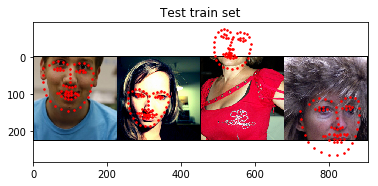

In [23]:
visualize_model(model_ft)

In [24]:
import cv2
#my_pict_url = 'test_face/lan.jpg'

def test_face_detection(url):
    img = io.imread(url)

    resized_image = cv2.resize(img, (224, 224)) 
    #print(resized_image.shape)
    resized_image = resized_image.transpose(0,1,2)

    transform1 = transforms.Compose([  
        transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]  
        ]  
    )  


    with torch.no_grad():

        new_img = transform1(resized_image)
        new_img = new_img.view(1,3,224,224)
        new_img = new_img.to(device)
        #print(new_img.size())
        landmarks_batch = model_ft(new_img)
        landmarks_batch = landmarks_batch.view(landmarks_batch.size(0),68,-1)
        landmarks_batch = landmarks_batch.cpu()

        landmarks_batch.numpy()

        batch_size = len(new_img)
        im_size = images_batch.size(2)
        
        plt.figure()
        plt.imshow(resized_image)
        

        for i in range(batch_size):
            plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                        landmarks_batch[i, :, 1].numpy(),
                        s=10, marker='^', c='r')

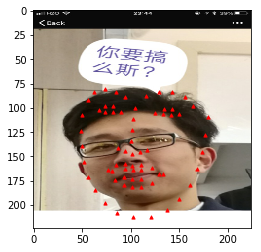

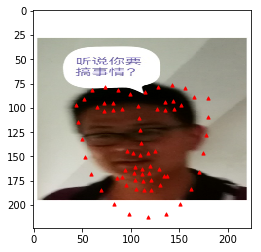

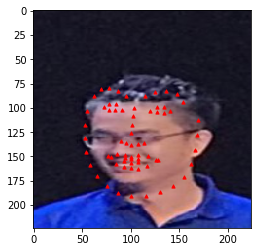

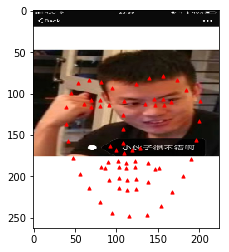

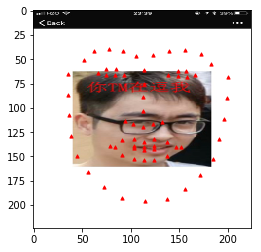

In [25]:
urls = ["lan.jpg","zhe.jpg","shu.jpeg","tan.jpg","yun.jpg"]
for url in urls:
    url = os.path.join("test_face",url)
    test_face_detection(url)